# Importing Packages

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm.notebook import tqdm

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers, optimizers, applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import ResNet50

from sklearn.metrics import confusion_matrix

%reload_ext autoreload
%autoreload 2
from utils import *


# ResNet50

In [2]:
cnn_base = ResNet50(include_top=False,
                    weights="imagenet",
                    input_shape=(224, 224, 3))

model = models.Sequential()
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=64, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units=128, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units=256, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units=128, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units=1, activation='sigmoid'))

cnn_base.trainable = False

In [3]:
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test2'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42
)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (224, 224),
        batch_size = 1,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

Found 3830 images belonging to 2 classes.
Found 678 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [ ]:
X_test, y_test = next(test_generator)

In [4]:
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.AUC(curve='PR')])

In [5]:
filepath = '../models/Resnet.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit_generator(generator = train_generator,
                             epochs = 20,
                             callbacks = [earlyStopping, mcp_save],
                             validation_data = val_generator,
                             steps_per_epoch = len(train_generator)) 

Epoch 1/20
240/240 [==============================] - 1984s 8s/step - loss: 4.3426 - accuracy: 0.6548 - precision: 0.6836 - recall: 0.9291 - auc: 0.4602 - auc_1: 0.6654 - val_loss: 0.4182 - val_accuracy: 0.9587 - val_precision: 0.9587 - val_recall: 1.0000 - val_auc: 0.5000 - val_auc_1: 0.9587
Epoch 2/20
240/240 [==============================] - 1774s 7s/step - loss: 0.6373 - accuracy: 0.6713 - precision: 0.6713 - recall: 1.0000 - auc: 0.4812 - auc_1: 0.6596 - val_loss: 0.3867 - val_accuracy: 0.9587 - val_precision: 0.9587 - val_recall: 1.0000 - val_auc: 0.5000 - val_auc_1: 0.9587
Epoch 3/20
240/240 [==============================] - 1774s 7s/step - loss: 0.6265 - accuracy: 0.6840 - precision: 0.6840 - recall: 1.0000 - auc: 0.4937 - auc_1: 0.6777 - val_loss: 0.3919 - val_accuracy: 0.9587 - val_precision: 0.9587 - val_recall: 1.0000 - val_auc: 0.5000 - val_auc_1: 0.9587
Epoch 4/20
240/240 [==============================] - 1752s 7s/step - loss: 0.6302 - accuracy: 0.6778 - precision: 0.6

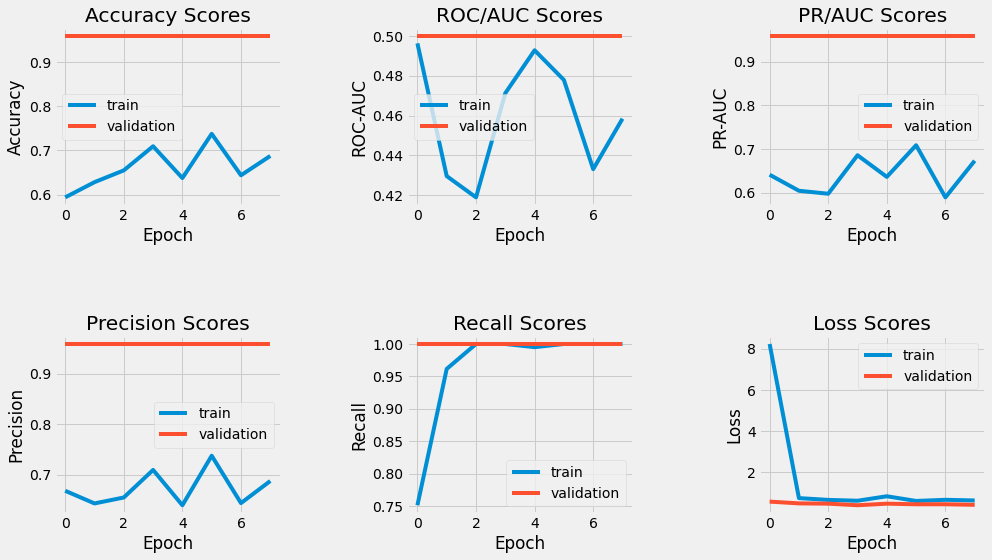

In [8]:
sixplot(history, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [10]:
hist_df = pd.DataFrame(history.history)
hist_df

,loss,accuracy,precision,recall,auc,auc_1,val_loss,val_accuracy,val_precision,val_recall,val_auc,val_auc_1
0,8.227907,0.593750,0.668085,0.751196,0.496336,0.641167,0.571653,0.958702,0.958702,1.0,0.5,0.958702
1,0.741764,0.628125,0.643087,0.961538,0.429537,0.604439,0.485744,0.958702,0.958702,1.0,0.5,0.958702
2,0.654701,0.654839,0.654839,1.000000,0.418834,0.597624,0.472493,0.958702,0.958702,1.0,0.5,0.958702
3,0.613993,0.709375,0.709375,1.000000,0.471271,0.685780,0.395665,0.958702,0.958702,1.0,0.5,0.958702
4,0.830817,0.637500,0.639498,0.995122,0.492874,0.636239,0.471343,0.958702,0.958702,1.0,0.5,0.958702
5,0.603918,0.737500,0.737500,1.000000,0.477931,0.708759,0.442330,0.958702,0.958702,1.0,0.5,0.958702
6,0.659130,0.643750,0.643750,1.000000,0.433040,0.589335,0.443566,0.958702,0.958702,1.0,0.5,0.958702
7,0.626881,0.687500,0.687500,1.000000,0.458432,0.673223,0.414950,0.958702,0.958702,1.0,0.5,0.958702


In [ ]:
def train_val_metrics(epochs, model_training):
    epochs = range(1, epochs+1)
    metrics = model_training.history
    train_loss = metrics['loss']
    train_acc = metrics['acc']
    val_loss = metrics['val_loss']
    val_acc = metrics['val_acc']
    
    ax = plt.subplot(211)
    train, = ax.plot(epochs, train_loss)
    val, = ax.plot(epochs, val_loss)
    ax.legend([train, val], ['training', 'validation'])
    ax.set(xlabel='epochs', ylabel='categorical cross-entropy loss')

    ax2 = plt.subplot(212)
    train2, = ax2.plot(epochs, train_acc)
    val2, = ax2.plot(epochs, val_acc)
    ax2.legend([train2, val2], ['training', 'validation'])
    ax2.set(xlabel='epochs', ylabel='accuracy')

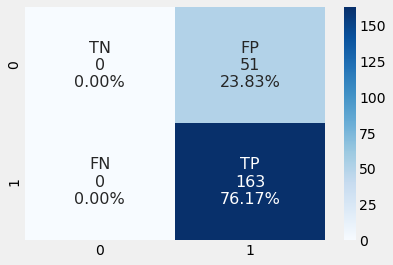

In [11]:
probabilities = model.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5
make_confusion_matrix(y_true, y_pred)

# AlexNet

In [14]:
#Instantiation
def AlexNet():
    return Sequential([
        Conv2D(filters=96, input_shape=(224, 224, 3), kernel_size=(11, 11), strides=(4, 4), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        Flatten(),
        Dense(4096, input_shape=(224, 224, 3, )),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.4),
        Dense(4096),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.4),
        Dense(1000),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.4),
        Dense(1),
        BatchNormalization(),
        Activation('sigmoid'),
        ])

In [16]:
AlexNet().compile(loss = 'binary_crossentropy',
                optimizer = Adam(learning_rate=0.001),
                metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

In [17]:
filepath = '../models/Alexnet.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history2 = AlexNet.fit(train_generator,
                      epochs = 20,
                      callbacks = [earlyStopping, mcp_save],
                      validation_data = val_generator,
                      batch_size = 16)

Epoch 1/20
240/240 [==============================] - 828s 3s/step - loss: 0.4897 - accuracy: 0.8231 - precision_2: 0.8803 - recall_2: 0.8625 - auc_4: 0.8679 - auc_5: 0.9180 - val_loss: 0.2815 - val_accuracy: 0.9558 - val_precision_2: 0.9599 - val_recall_2: 0.9954 - val_auc_4: 0.6688 - val_auc_5: 0.9713
Epoch 2/20
240/240 [==============================] - 788s 3s/step - loss: 0.4065 - accuracy: 0.8544 - precision_2: 0.8943 - recall_2: 0.8867 - auc_4: 0.9240 - auc_5: 0.9484 - val_loss: 0.2638 - val_accuracy: 0.9484 - val_precision_2: 0.9583 - val_recall_2: 0.9892 - val_auc_4: 0.6725 - val_auc_5: 0.9754
Epoch 3/20
240/240 [==============================] - 747s 3s/step - loss: 0.3453 - accuracy: 0.8935 - precision_2: 0.9295 - recall_2: 0.9149 - auc_4: 0.9454 - auc_5: 0.9696 - val_loss: 0.5238 - val_accuracy: 0.7581 - val_precision_2: 0.9728 - val_recall_2: 0.7692 - val_auc_4: 0.6530 - val_auc_5: 0.9709
Epoch 4/20
240/240 [==============================] - 740s 3s/step - loss: 0.3255 - a

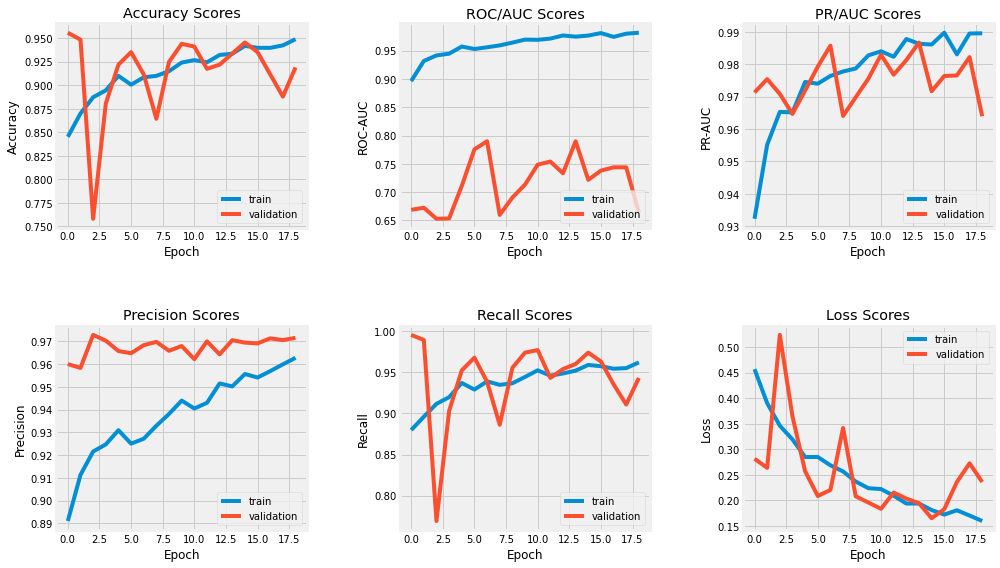

In [21]:
sixplot(history2, 'auc_4', 'val_auc_4', 'auc_5', 'val_auc_5', 'precision_2', 'val_precision_2', 'recall_2', 'val_recall_2')

In [22]:
hist_df_2 = pd.DataFrame(history2.history)
hist_df_2

,loss,accuracy,precision_2,recall_2,auc_4,auc_5,val_loss,val_accuracy,val_precision_2,val_recall_2,val_auc_4,val_auc_5
0,0.456796,0.845170,0.891051,0.879754,0.896119,0.932304,0.281483,0.955752,0.959941,0.995385,0.668846,0.971292
1,0.390248,0.869974,0.911293,0.895889,0.931545,0.955177,0.263782,0.948378,0.958271,0.989231,0.672500,0.975418
2,0.346168,0.887206,0.921553,0.911640,0.941409,0.965310,0.523784,0.758112,0.972763,0.769231,0.652967,0.970857
3,0.319338,0.894517,0.924681,0.919708,0.944458,0.965154,0.364373,0.880531,0.970248,0.903077,0.653599,0.964680
4,0.284920,0.909922,0.930916,0.936996,0.957087,0.974551,0.257132,0.921829,0.965679,0.952308,0.711071,0.971905
5,0.285052,0.900522,0.925019,0.928928,0.952726,0.974015,0.208666,0.935103,0.964724,0.967692,0.775522,0.979279
6,0.268668,0.908355,0.927162,0.938917,0.955761,0.976405,0.220458,0.911504,0.968254,0.938462,0.789918,0.985753
7,0.256750,0.909922,0.932899,0.934691,0.959107,0.977785,0.341787,0.864307,0.969697,0.886154,0.659863,0.964042
8,0.236913,0.914882,0.938053,0.936612,0.964011,0.978697,0.208071,0.924779,0.965785,0.955385,0.690412,0.969817
9,0.223941,0.924021,0.943932,0.944295,0.969311,0.982755,0.195842,0.943953,0.967890,0.973846,0.713379,0.975566


In [25]:
prob = AlexNet.predict_generator(test_generator)
y_true = test_generator.classes
y_pred2 = prob > 0.5


6

In [26]:
len(y_pred2)

214

In [29]:
X_test.shape

(1, 224, 224, 3)

In [24]:
score = AlexNet.evaluate(X_test, y_test, verbose = 0)
labels = AlexNet.metrics_names

print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

loss: 0.026970352977514267
accuracy: 1.0


In [ ]:
base_model = applications.resnet50.ResNet50(include_top=False, input_shape=(256, 256, 3), weights="imagenet")
base_model.trainable = False

model = models.Sequential([
        base_model,
        layers.Conv2D(32, (3, 3), activation="relu"),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='softmax'),
])

model.compile(loss = 'binary_crossentropy', 
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

In [ ]:
history_3 = model.fit(train_generator, 
                      epochs = 5,
                      steps_per_epoch = 20,
                      validation_data = val_generator,
                      validation_steps = 20)

In [ ]:
base_model = keras.applications.ResNet50(weights= None, include_top=False, input_shape= (256, 256, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)

predictions = Dense(2, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

model.compile(loss = 'binary_crossentropy', 
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])